# nb018

*  [UWMGI: 2.5D [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-train-pytorch)
* **2.5D data**
* UNet

**efficient net b4**
* epoch20
* nb016と比較


**各IDについてどのような予測が行われたかのログもとる**



In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/kaggle/UWMGI/

# シンボリックリンクを作成
!ln -sfn /content/drive/MyDrive/kaggle/UWMGI/ /content/workspace

#!apt-get install vim
# kaggle api
#!pip install kaggle
!pip install segmentation_models_pytorch
!pip install wandb

# current directory 変更
import os
# path を通す
import sys
sys.path.append("../")

# import したもの自動reloadする設定
%load_ext autoreload
%autoreload 2

os.environ["KAGGLE_CONFIG_DIR"] = "/content/workspace"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/kaggle/UWMGI
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil
import copy
from tqdm import tqdm_notebook as tqdm
import time
from collections import defaultdict
import gc
import h5py
import pdb
import cupy as cp

# visualization
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import segmentation_models_pytorch as smp

# image deeplearning models library
import timm

# Albumentations for augmentations
import albumentations as album
#from albumentations.pytorch import ToTensorV2

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# wandb
import wandb

In [3]:
class CFG:
    seed = 101
    debug = False
    exp_name = "nb018"
    model_name = "Unet"
    backbone = "efficientnet-b4"
    comment = "unet-efficientnet_b4-320*385-ep15"
    train_bs = 32 if debug == False else 20
    valid_bs = 32 if debug == False else 20
    img_size = [320, 384] # 実質img25Dそのもののサイズで学習を行っている [320, 384]
    channels = 3
    epochs = 15
    lr = 2e-3
    scheduler = "CosineAnnealingLR"
    min_lr = 1e-6
    T_max = int(30000 / train_bs * epochs) + 50
    T_0 = 25
    warmup_epochs = 0
    wd = 1e-6
    n_accumulate = max(1, 32 // train_bs)
    n_fold = 3
    num_classes = 3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    thr = 0.4
    log_imgs = 500 * n_fold

# environment variable
NUM_WORKERS = os.cpu_count()
HDF5_PATH = './data/dataset.hdf5'
# 学習高速化するが計算の再現性はなくなることに注意する
torch.backends.cudnn.benchmark = True

def class2dic(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith("__"))


## Reproducibility

In [4]:
def set_seed(seed = 35):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(CFG.seed)

In [5]:
df = pd.read_csv("./data/train_v4.csv")
columns = ["id", "segmentation", "case", "day", "slice", "path", "image_height", "image_width", "exist_segmentation", "mask3D_path", "mask2D_path"]
df = df[columns]

# case7_day0, case81_day30はannotationのミスがあるらしい
case7_day0 = (df["case"] == 7) & (df["day"] == 0)
case81_day30 = (df["case"] == 81) & (df["day"] == 30)
df = df[~(case7_day0 | case81_day30)]
df = df.reset_index()

df["img_path"] = '/img25D/channel3-stride2-back/' + df["id"]
df["mask_path"] = '/mask25D/channel3-stride2-back/' + df["id"]
df.head()

,index,id,segmentation,case,day,slice,path,image_height,image_width,exist_segmentation,mask3D_path,mask2D_path,img_path,mask_path
0,0,case2_day1_slice_0001,NaN,2,1,1,./data/train/case2/case2_day1/scans/slice_0001...,266,266,False,./data/masks_png/case2_day1_slice_0001.png,./data/masks2D_png/case2_day1_slice_0001.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
1,1,case2_day1_slice_0002,NaN,2,1,2,./data/train/case2/case2_day1/scans/slice_0002...,266,266,False,./data/masks_png/case2_day1_slice_0002.png,./data/masks2D_png/case2_day1_slice_0002.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
2,2,case2_day1_slice_0003,NaN,2,1,3,./data/train/case2/case2_day1/scans/slice_0003...,266,266,False,./data/masks_png/case2_day1_slice_0003.png,./data/masks2D_png/case2_day1_slice_0003.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
3,3,case2_day1_slice_0004,NaN,2,1,4,./data/train/case2/case2_day1/scans/slice_0004...,266,266,False,./data/masks_png/case2_day1_slice_0004.png,./data/masks2D_png/case2_day1_slice_0004.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
4,4,case2_day1_slice_0005,NaN,2,1,5,./data/train/case2/case2_day1/scans/slice_0005...,266,266,False,./data/masks_png/case2_day1_slice_0005.png,./data/masks2D_png/case2_day1_slice_0005.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...


## Image

In [6]:
def load_img_3channels(path):
    img = cv.imread(path, cv.IMREAD_UNCHANGED)
    # gray -> 1 channel rgb -> 3 channels
    img = np.tile(img[..., None], [1, 1, 3])
    img = img.astype("float32")
    return img

def load_img(path):
    img = cv.imread(path, cv.IMREAD_UNCHANGED)
    img = cv.normalize(img, None, alpha = 0, beta = 255, 
                        norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
    img = img.astype(np.uint8)
    return img

def load_mask(path):
    mask = cv.imread(path, cv.IMREAD_UNCHANGED)
    mask = mask.astype("float32")
    return mask

def load_data_from_hdf5(path, hdf5_file_path):
    """
    path: path in the hdf5 file
    hdf5_file_path: path of the hdf5 file
    """
    f = h5py.File(hdf5_file_path, 'r')
    img = f[path][...]
    img = img.astype(np.float)
    mx = np.max(img)
    # scale image to [0, 1]
    if mx:
        img /= mx
    return img

def normalize_img(img):
    img = img.astype(np.float)
    mx = img.max()
    if mx:
        img /= mx
    return img
    
def convert_img_1channel_to_3channels(img):
    """
    img (numpy array): img of 1 channels (gray scale)
    return res (numpy array): img of 3 channels (3 channels)
    """
    res = np.tile(img[..., None], [1, 1, 3])
    return res

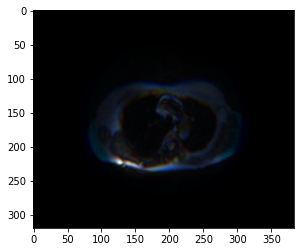

In [7]:
# test load_img_from_hdf5
path = '/img25D/channel3-stride2-back/case2_day1_slice_0001'
img = load_data_from_hdf5(path, HDF5_PATH)
plt.imshow(img)

## RLE

In [8]:
def rle_decode(mask_rle, shape):
    """
    mask_rle: run-length as string format (start length)
    shape: (height, width) of array to return
    Return: 1 = mask, 0 = background
    """
    segm = np.asarray(mask_rle.split(), dtype=int)
    start_points = segm[0::2] - 1
    length_points = segm[1::2]
    
    end_points = start_points + length_points

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(start_points, length_points):
        img[start: end] = 1

    img = img.reshape(shape)
    return img

def rle_encode(img):
    """
    img: numpy array, 1 (mask), 0 (background)
    Return run-length as string format
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = np.array(msk)
    pixels = msk.flatten()
    pad    = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs   = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks2rles(msks, ids, heights, widths, dice_scores, iou_scores):
    res_lis = []
    for idx in range(msks.shape[0]):
        res_dic = {}
        res_dic['id'] = ids[idx]

        height = heights[idx].item()
        width = widths[idx].item()
        dice = dice_scores[idx].item()
        iou = iou_scores[idx].item()
        res_dic['train_height'] = height
        res_dic['train_width'] = width
        res_dic['dice_scores'] = dice
        res_dic['iou_scores'] = iou
        
        # msk (h, w, 3)
        msk = msks[idx]
        # 0 -> large_bowel, 1 -> small_bowel, 2 -> stomach
        for midx, organ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
            rle = mask2rle(msk[...,midx])
            res_dic[organ] = rle
        
        res_lis.append(res_dic)
        
    return res_lis

## visualization

In [9]:
# Yellow Purple Red
labels = ["Large Bowel", "Small Bowel", "Stomach"]

import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

# Custom color map in matplotlib
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]

def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    # １以外の部分は表示しない
    cmap_lis = cmap(np.arange(cmap.N))
    cmap_lis[:, 3] = 0
    cmap_lis[-1, 3] = 1
    cmap = colors.ListedColormap(cmap_lis)
    return cmap

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

def plot_original_mask(img, mask, alpha=1):
    # Change pixels - when 1 make True, when 0 make NA
    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]

    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img, cmap="gist_gray")
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img, cmap="gist_gray")
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
    fig.show()

def plot_img_and_mask(img, mask, alpha=1, ax=None):
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]
    
    if (ax == None):
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.imshow(img, cmap="gist_gray")
    ax.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax.legend(legend_colors, labels)
    ax.axis("off")

def plot_multiple_img_and_mask(id_list, hdf5_path=HDF5_PATH, alpha=1):
    file = h5py.File(hdf5_path, 'r')
    n = len(id_list)

    rows, cols = 5, n + 4 // 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * rows, 5 * cols))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if (i < n):
            id = id_list[i]
            img = file['img'][id][...]
            mask = file['mask3D'][id][...]
            plot_img_and_mask(img, mask, ax=ax)
        else:
            ax.set_visible(False)
    return

### check img and mask3D
### check img2.5D and mas2.5D

(320, 384, 3) (320, 384, 3)


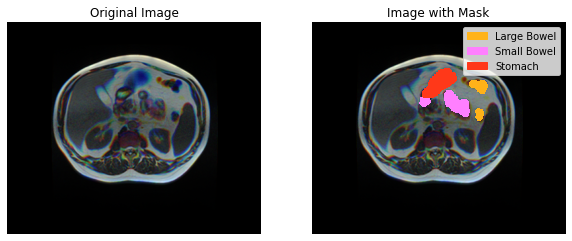

In [10]:
id = 'case123_day20_slice_0090'
img_path_in_hdf5 = f'img25D/channel3-stride2-back/{id}'
mask_path_in_hdf5 = f'mask25D/channel3-stride2-back/{id}'
img = load_data_from_hdf5(img_path_in_hdf5, HDF5_PATH)
mask = load_data_from_hdf5(mask_path_in_hdf5, HDF5_PATH)
plot_original_mask(img, mask)
print(img.shape, mask.shape)

## Create Folds

In [11]:
fold_df = pd.read_csv("./data/id-fold.csv")

df = pd.merge(df, fold_df, on="id", how="left")
df.drop(columns=["index"], inplace=True)
df.head()

,id,segmentation,case,day,slice,path,image_height,image_width,exist_segmentation,mask3D_path,mask2D_path,img_path,mask_path,fold
0,case2_day1_slice_0001,NaN,2,1,1,./data/train/case2/case2_day1/scans/slice_0001...,266,266,False,./data/masks_png/case2_day1_slice_0001.png,./data/masks2D_png/case2_day1_slice_0001.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
1,case2_day1_slice_0002,NaN,2,1,2,./data/train/case2/case2_day1/scans/slice_0002...,266,266,False,./data/masks_png/case2_day1_slice_0002.png,./data/masks2D_png/case2_day1_slice_0002.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
2,case2_day1_slice_0003,NaN,2,1,3,./data/train/case2/case2_day1/scans/slice_0003...,266,266,False,./data/masks_png/case2_day1_slice_0003.png,./data/masks2D_png/case2_day1_slice_0003.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
3,case2_day1_slice_0004,NaN,2,1,4,./data/train/case2/case2_day1/scans/slice_0004...,266,266,False,./data/masks_png/case2_day1_slice_0004.png,./data/masks2D_png/case2_day1_slice_0004.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
4,case2_day1_slice_0005,NaN,2,1,5,./data/train/case2/case2_day1/scans/slice_0005...,266,266,False,./data/masks_png/case2_day1_slice_0005.png,./data/masks2D_png/case2_day1_slice_0005.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2


## Dataset

In [12]:
class BuildDataset(Dataset):
    def __init__(self, df, label=True, transforms=None, hdf5_path=HDF5_PATH):
        self.df = df
        self.label = label
        self.ids = df["id"].tolist()
        self.img_paths = df["img_path"].tolist()
        self.mask_paths = df["mask_path"].tolist()
        self.transforms = transforms
        self.f = h5py.File(hdf5_path, 'r')
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = self.f[img_path][...]
        # range [0, 1]
        img = normalize_img(img)
        if (len(img.shape) == 2):
            # 1 channel -> 3 channels
            img = convert_img_1channel_to_3channels(img)

        if self.label:
            mask_path = self.mask_paths[idx]
            msk = self.f[mask_path][...]
            msk = msk.astype(np.float)
            if self.transforms(image=img, mask=msk):
                data = self.transforms(image=img, mask=msk)
                img = data["image"]
                msk = data["mask"]
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img = data["image"]
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

class BuildTestDataset(Dataset):
    def __init__(self, df, hdf5_path=HDF5_PATH):
        self.df = df
        self.ids = df["id"].tolist()
        self.img_paths = df["img_path"].tolist()
        self.mask_paths = df["mask_path"].tolist()
        self.f = h5py.File(hdf5_path, 'r')

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        id = self.ids[idx]
        
        img_path = self.img_paths[idx]
        img = self.f[img_path][...]
        # img (h, w, c)
        h, w = img.shape[:2]
        # range [0, 1]
        img = normalize_img(img)
        if (len(img.shape) == 2):
            # 1 channel -> 3 channels
            img = convert_img_1channel_to_3channels(img)
        img = np.transpose(img, (2, 0, 1))

        msk_path = self.mask_paths[idx]
        msk = self.f[msk_path][...]
        msk = np.transpose(msk, (2, 0, 1))
        msk = msk.astype(np.float)
        
        return torch.tensor(img), msk, id, h, w

## Augumentations

In [13]:
data_transforms = {
    "train": album.Compose([
 #       album.Resize(*CFG.img_size, interpolation=cv.INTER_NEAREST, p=1.0),
        album.HorizontalFlip(p=0.5),
 #       album.VerticalFlip(p=0.5),
        album.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
        album.OneOf([
            album.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            album.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
        ], p=0.25)
    ], p=1.0),
    "valid": album.Compose([
 #       album.Resize(*CFG.img_size, interpolation=cv.INTER_NEAREST)
    ], p=1.0)
}

## DataLoader

In [14]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold != @fold").reset_index(drop=True)
    valid_df = df.query("fold == @fold").reset_index(drop=True)

    if debug:
        train_df = train_df.head(32*5)
        valid_df = train_df.head(32*5)
    
    train_dataset = BuildDataset(train_df, transforms=data_transforms["train"])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset,
                              batch_size = CFG.train_bs,
                              num_workers = NUM_WORKERS,
                              shuffle = True,
                              pin_memory = True,
                              drop_last = False)
    valid_loader = DataLoader(valid_dataset,
                              batch_size = CFG.valid_bs,
                              num_workers = NUM_WORKERS,
                              shuffle = False,
                              pin_memory = True)
    return train_loader, valid_loader

def prepare_test_loaders(df, fold, debug=False):
    test_df = df.query("fold == @fold").reset_index(drop=True)
    test_df = test_df.sample(n=CFG.log_imgs // CFG.n_fold, random_state=CFG.seed)
    test_df.reset_index(inplace=True)

    if debug:
        test_df = test_df.head(32 * 5)
    
    test_dataset = BuildTestDataset(test_df)
    test_loader = DataLoader(test_dataset,
                             batch_size=CFG.valid_bs,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=True,
                             drop_last=False)
    return test_loader

## Loss Function

In [15]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=CFG.thr, dim=(2,3), epsilon=0.001, remain_batch=False):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    if remain_batch:
        dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=1)
    else:
        dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=CFG.thr, dim=(2,3), epsilon=0.001, remain_batch=False):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    if remain_batch:
        iou = ((inter+epsilon)/(union+epsilon)).mean(dim=1)
    else:
        iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(0, 1))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [16]:
def build_model():
    model = smp.Unet(encoder_name=CFG.backbone,
                     encoder_weights="imagenet",
                     in_channels=CFG.channels,
                     classes=CFG.num_classes,
                     activation=None)
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

## Optimizer

In [17]:
def get_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                   T_max=CFG.T_max,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                             T_0=CFG.T_0,
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [18]:
# test dataloader
# train_loader, valid_laoder= prepare_loaders(fold=0, debug=True)
# data_iter = iter(train_loader)
# imgs, masks = data_iter.next()
# print(imgs.shape)
# print(masks.shape)

In [19]:
# test testloader
# test_loader = prepare_test_loaders(df, fold=0, debug=True)
# imgs, masks, ids, h, w = next(iter(test_loader))
# print(imgs.shape)
# print(masks.shape)
# print(ids)

In [20]:
# idx = 19
# img = imgs[idx].permute(1, 2, 0).numpy()
# mask = masks[idx].permute(1, 2, 0).squeeze(-1).numpy()
# plot_original_mask(img, mask)
# print(np.unique(mask))

In [21]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc = 'Train ')
    for step, (imgs, masks) in pbar:
        imgs = imgs.to(device, non_blocking=True, dtype=torch.float)
        masks = masks.to(device, non_blocking=True, dtype=torch.float)

        with amp.autocast(enabled = True):
            y_pred = model(imgs)
            loss = criterion(y_pred, masks)
            loss = loss / CFG.n_accumulate
        
        scaler.scale(loss).backward()

        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()
            
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        #grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1e9 \
                    if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]["lr"]
        pbar.set_postfix(train_loss = f'{epoch_loss: 0.4f}',
                         lr = f'{current_lr: 0.5f}',
                         gpu_memory = f'{mem: 0.2f} GB')
    
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss


In [22]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    running_loss = 0.0
    dataset_size = 0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc = 'Valid ')
    for step, (imgs, masks) in pbar:
        imgs = imgs.to(CFG.device, non_blocking=True, dtype=torch.float)
        masks = masks.to(CFG.device, non_blocking=True, dtype=torch.float)

        y_pred = model(imgs)
        loss = criterion(y_pred, masks)

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
        pbar.set_postfix(valid_loss = f'{epoch_loss: 0.4f}',
                         gpu_memory = f'{mem: 0.2f} GB')
        
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores

@torch.no_grad()
def infer(model, test_loader, thr=CFG.thr):
    records = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Infer ')
    for i, (imgs, masks, ids, heights, widths) in pbar:
        imgs = imgs.to(CFG.device, non_blocking=True, dtype=torch.float)
        masks = masks.to(CFG.device, non_blocking=True, dtype=torch.float)
        
        outs = model(imgs)
        outs = nn.Sigmoid()(outs) # removing channel axis
        # score
        val_dice = dice_coef(masks, outs, remain_batch=True).cpu().detach().numpy()
        #val_dice = dice_coef(masks, outs, remain_batch=True)
        val_jaccard = iou_coef(masks, outs, remain_batch=True).cpu().detach().numpy()
        #val_jaccard = iou_coef(masks, outs, remain_batch=True)
        # pred rle and size
        preds = (outs.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        record = masks2rles(preds, ids, heights, widths, val_dice, val_jaccard)
        records.extend(record)

        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
        pbar.set_postfix(gpu_memory = f'{mem: 0.2f} GB')

        gc.collect()
        torch.cuda.empty_cache()
    
    records = pd.DataFrame(records)
    return records

In [23]:
# model = build_model()
# test_loader = prepare_test_loaders(df, fold=0, debug=True)
# log_history = infer(model, test_loader)

In [24]:
# row = log_history.iloc[1]
# ID = row["id"]
# print(ID)
# train_img_shape = log_history.loc[log_history.id == ID, ['train_height', 'train_width']].values[0]

# mask3D = np.array([rle_decode(rle, train_img_shape) for rle in row[['large_bowel', 'small_bowel', 'stomach']]])
# mask3D = np.transpose(mask3D, (1, 2, 0))

# img_path_in_hdf5 = f'img25D/channel3-stride2-back/{ID}'
# truth_path_in_hdf5 = f'mask25D/channel3-stride2-back/{ID}'
# img = load_data_from_hdf5(img_path_in_hdf5, HDF5_PATH)
# grand_truth = load_data_from_hdf5(truth_path_in_hdf5, HDF5_PATH)

# plot_original_mask(img, mask3D)
# print(mask3D.sum())
# plot_original_mask(img, grand_truth)

In [25]:
def run_training(model, optimizer, scheduler, device, fold):
    # to automatically log gradients
    wandb.watch(model, log_freq = 100)

    # train_loader, valid_loader
    train_loader, valid_loader = prepare_loaders(fold = fold, debug = CFG.debug)

    start = time.time()
    best_models_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    # 指定していないkeyを参照してもerrorでない
    history = defaultdict(list)

    for epoch in range(1, CFG.epochs + 1):
        gc.collect()
        print(f"Epoch {epoch} / {CFG.epochs}", end="")
        
        train_loss = train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch)
        val_loss, val_scores = valid_one_epoch(model, valid_loader, device, epoch)
        val_dice, val_jaccard = val_scores

        history["Train Loss"].append(train_loss)
        history["Valid Loss"].append(val_loss)
        history["Valid Dice"].append(val_dice)
        history["Valid Jaccard"].append(val_jaccard)

        # log the metrics
        wandb.log({f"[fold{fold}] Train Loss": train_loss,
                   f"[fold{fold}] Valid Loss": val_loss,
                   f"[fold{fold}] Valid Dice": val_dice,
                   f"[fold{fold}] Valid Jaccrad": val_jaccard,
                   f"[fold{fold}] LR": scheduler.get_last_lr()[0]})
        
        print(f"Valid Dice: {val_dice: 0.4f} | Valid Jaccard: {val_jaccard: 0.4f}")

        if val_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice: 0.4f} ---> {val_dice: 0.4f})")
            best_dice = val_dice
            best_jaccard = val_jaccard
            best_epoch = epoch
            wandb.run.summary["Best Dice"] = best_dice
            wandb.run.summary["Best Jaccard"] = best_jaccard
            wandb.run.summary["Best Epoch"] = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            save_path_dir = f"./model/{CFG.exp_name}"
            if (os.path.exists(save_path_dir) == False):
                os.mkdir(save_path_dir)
            save_file_name = f"{CFG.exp_name}-{fold}-best.bin"
            save_path = os.path.join(save_path_dir, save_file_name)
            torch.save(model.state_dict(), save_path)
            
    end = time.time()
    time_elapsed = end - start
    print("Training complete in {:.0f}h {:.0f}m {:.0f}s".format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60)
    )
    print("Best Score: {:.4f}".format(best_jaccard))

    model.load_state_dict(best_model_wts)
    history = pd.DataFrame(history)

    # このfoldで最も性能が良かったモデルの予測値
    

    return model, history

In [ ]:
wandb.init(project = 'UW-Maddison-GI-Tract',
                  config = class2dic(CFG),
                  name = CFG.exp_name,
                  group = CFG.comment)

log_df = pd.DataFrame()
for fold in range(CFG.n_fold):
    print('#' * 15)
    print(f'Fold: {fold}')
    print('#' * 15)

    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr = CFG.lr, weight_decay = CFG.wd)
    scheduler = get_scheduler(optimizer)
    model, _ = run_training(model, optimizer, scheduler, CFG.device, fold)

    test_loader = prepare_test_loaders(df, fold)
    log_history = infer(model, test_loader)
    log_df = pd.concat([log_df, log_history]).reset_index(drop=True)
    log_df.sort_values(by="id", inplace=True)
    log_df.to_pickle(f"./model/{CFG.exp_name}/log_history.pkl")
    
wandb.finish()

wandb: Currently logged in as: yoshoo. Use `wandb login --relogin` to force relogin


###############
Fold: 0
###############
Epoch 1 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.8080 | Valid Jaccard:  0.7750
Valid Score Improved (-inf --->  0.8080)
Epoch 2 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.8734 | Valid Jaccard:  0.8417
Valid Score Improved ( 0.8080 --->  0.8734)
Epoch 3 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.8765 | Valid Jaccard:  0.8456
Valid Score Improved ( 0.8734 --->  0.8765)
Epoch 4 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.8977 | Valid Jaccard:  0.8677
Valid Score Improved ( 0.8765 --->  0.8977)
Epoch 5 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.8911 | Valid Jaccard:  0.8611
Epoch 6 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9045 | Valid Jaccard:  0.8762
Valid Score Improved ( 0.8977 --->  0.9045)
Epoch 7 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9051 | Valid Jaccard:  0.8780
Valid Score Improved ( 0.9045 --->  0.9051)
Epoch 8 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9030 | Valid Jaccard:  0.8758
Epoch 9 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9052 | Valid Jaccard:  0.8766
Valid Score Improved ( 0.9051 --->  0.9052)
Epoch 10 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9111 | Valid Jaccard:  0.8828
Valid Score Improved ( 0.9052 --->  0.9111)
Epoch 11 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9109 | Valid Jaccard:  0.8823
Epoch 12 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9116 | Valid Jaccard:  0.8852
Valid Score Improved ( 0.9111 --->  0.9116)
Epoch 13 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9131 | Valid Jaccard:  0.8859
Valid Score Improved ( 0.9116 --->  0.9131)
Epoch 14 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9149 | Valid Jaccard:  0.8876
Valid Score Improved ( 0.9131 --->  0.9149)
Epoch 15 / 15

Train :   0%|          | 0/816 [00:00<?, ?it/s]

Valid :   0%|          | 0/378 [00:00<?, ?it/s]

Valid Dice:  0.9138 | Valid Jaccard:  0.8870
Training complete in 5h 15m 37s
Best Score: 0.8876


Infer :   0%|          | 0/16 [00:00<?, ?it/s]

###############
Fold: 1
###############
Epoch 1 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.7165 | Valid Jaccard:  0.7142
Valid Score Improved (-inf --->  0.7165)
Epoch 2 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8606 | Valid Jaccard:  0.8329
Valid Score Improved ( 0.7165 --->  0.8606)
Epoch 3 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8673 | Valid Jaccard:  0.8371
Valid Score Improved ( 0.8606 --->  0.8673)
Epoch 4 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8719 | Valid Jaccard:  0.8414
Valid Score Improved ( 0.8673 --->  0.8719)
Epoch 5 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8809 | Valid Jaccard:  0.8503
Valid Score Improved ( 0.8719 --->  0.8809)
Epoch 6 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8896 | Valid Jaccard:  0.8596
Valid Score Improved ( 0.8809 --->  0.8896)
Epoch 7 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8813 | Valid Jaccard:  0.8536
Epoch 8 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8938 | Valid Jaccard:  0.8644
Valid Score Improved ( 0.8896 --->  0.8938)
Epoch 9 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8831 | Valid Jaccard:  0.8531
Epoch 10 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.9041 | Valid Jaccard:  0.8751
Valid Score Improved ( 0.8938 --->  0.9041)
Epoch 11 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]

Valid :   0%|          | 0/432 [00:00<?, ?it/s]

Valid Dice:  0.8984 | Valid Jaccard:  0.8687
Epoch 12 / 15

Train :   0%|          | 0/763 [00:00<?, ?it/s]